In [126]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
import sys
sys.path.append('../../..')

In [128]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from magrec.prop.Fourier import FourierTransform2d
from magrec.prop.Kernel import HarmonicFunctionComponentsKernel, MagneticFieldToCurrentInversion2d
from magrec.misc.plot import plot_n_components
from magrec.prop.Propagator import FourierPadder
from magrec.misc.load import load_matlab_data

from magrec import __datapath__

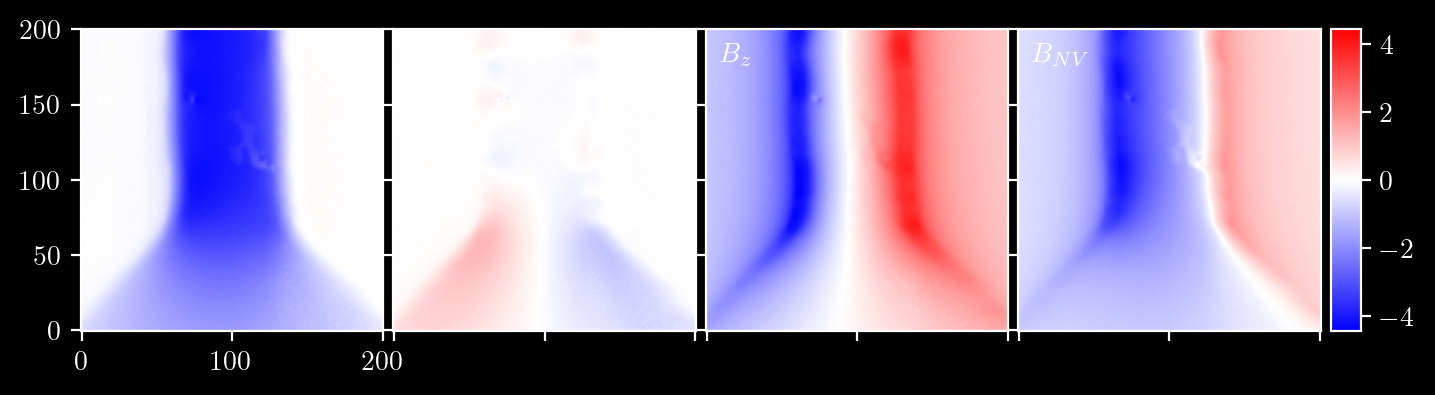

In [129]:
Bx = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bx.txt")
By = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "By.txt")
Bz = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bz.txt")

B = np.empty(shape=(4, 201, 201))

setTheta = np.deg2rad(54.7)
setPhi = np.deg2rad(45)

unv = [np.sin(setTheta) * np.cos(setPhi),
       np.sin(setTheta) * np.sin(setPhi),
       np.cos(setTheta)]

B[0, ::] = np.flipud(Bx)
B[1, ::] = np.flipud(By)
B[2, ::] = np.flipud(Bz)
B[3, ::] = np.flipud(Bx*unv[0] + By*unv[1] + Bz*unv[2])

B_NV = torch.from_numpy(B[3])

# B_NV = torch.concatenate((B_NV, torch.fliplr(B_NV)), axis=1)

plot_n_components(B, labels=[r'$B_x$', '$B_y$',
                  '$B_z$', '$B_{NV}$'], cmap="bwr")


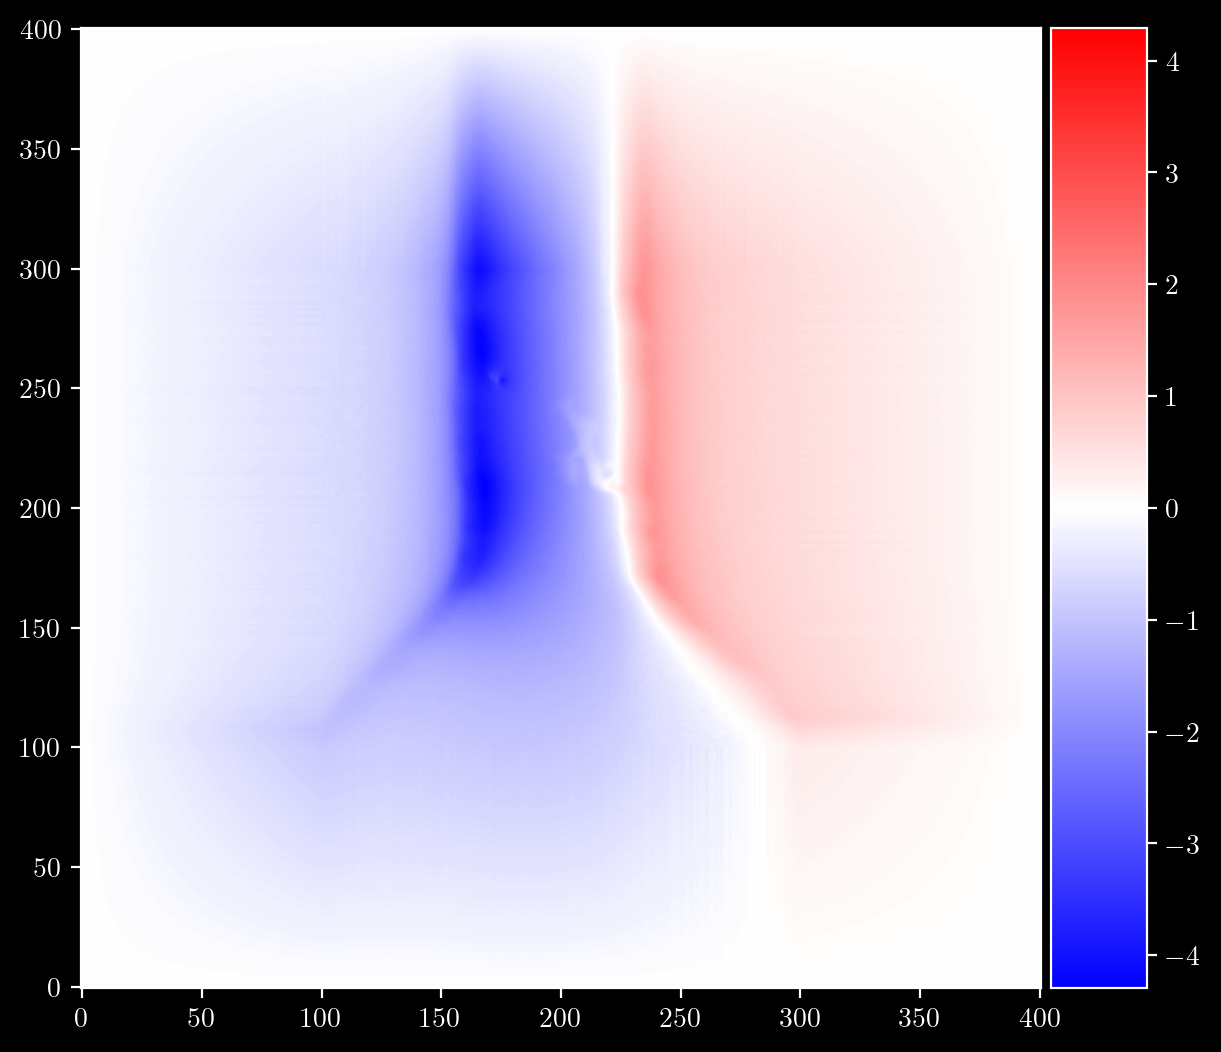

In [130]:
Bpad = FourierPadder.pad_2d(B_NV, (100,100), 'linear_ramp')
plot_n_components(Bpad, symmetric=True, cmap="bwr")

In [131]:
# data from inspecting the matlab file  
dx=0.408  # in μm
dy=0.408

# data from the .pptx shared by the authors
theta = np.rad2deg(setTheta)  # degrees
phi = np.rad2deg(setPhi)  # degrees

ft = FourierTransform2d(Bpad.shape, dx=dx, dy=dy)
kernel = HarmonicFunctionComponentsKernel.define_kernel_matrix(ft.kx_vector, ft.ky_vector, theta=theta, phi=phi)

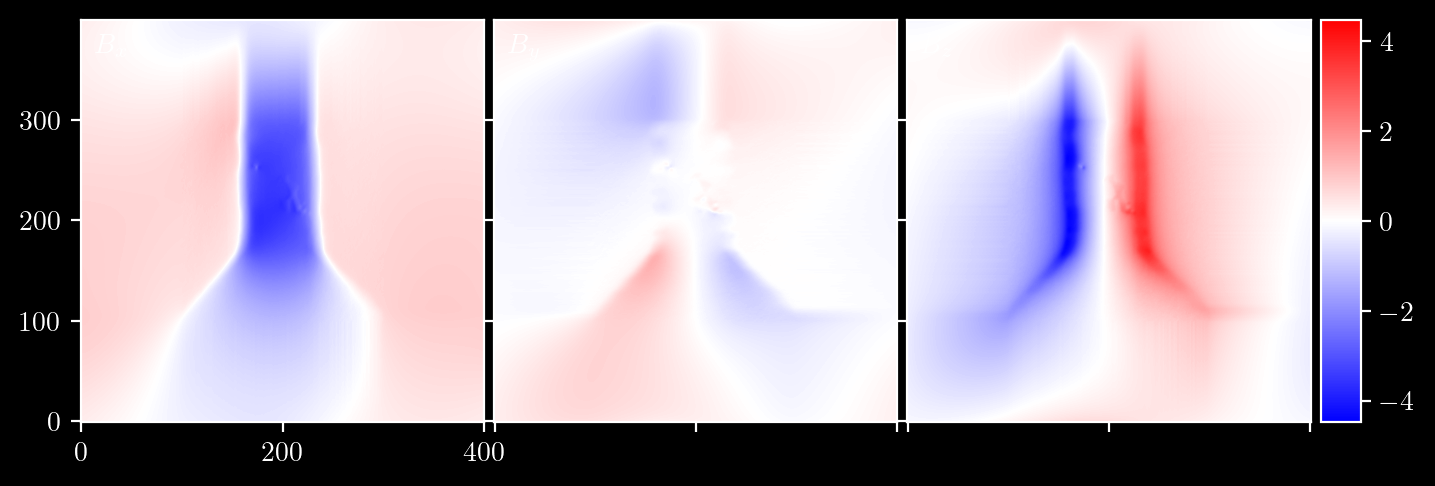

In [132]:
b_NV = ft.forward(Bpad, dim=(-2, -1))
b = torch.einsum("jkl,kl-> jkl", kernel, b_NV)
Bharmonic = ft.backward(b, dim=(-2, -1))
plot_n_components(Bharmonic, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic"})

In [133]:
height = 0.100 # in μm
layer_thickness = 0.03 # put 1 for now to get result per μm
inversion_kernel = MagneticFieldToCurrentInversion2d.define_kernel_matrix(ft.kx_vector, ft.ky_vector, height=height, layer_thickness=layer_thickness)

In [134]:
bxby = b[:2, :, :].type(dtype=torch.complex64)
jxjy = torch.einsum('vcjk,cjk->vjk', inversion_kernel, bxby)
jxjy[0,::] = FourierPadder.apply_hanning(
    jxjy[0,::], 
    ft.k_matrix, 
    height, 
    high_freq_cutoff = None, 
    low_freq_cutoff = None, 
    )
jxjy[1,::] = FourierPadder.apply_hanning(
    jxjy[1,::], 
    ft.k_matrix ,
    1*height, 
    high_freq_cutoff = height, 
    low_freq_cutoff = None)
JxJy = ft.backward(jxjy, dim=(-2, -1))

Applied a high frequency filter, removing all components smaller than 0.1 um


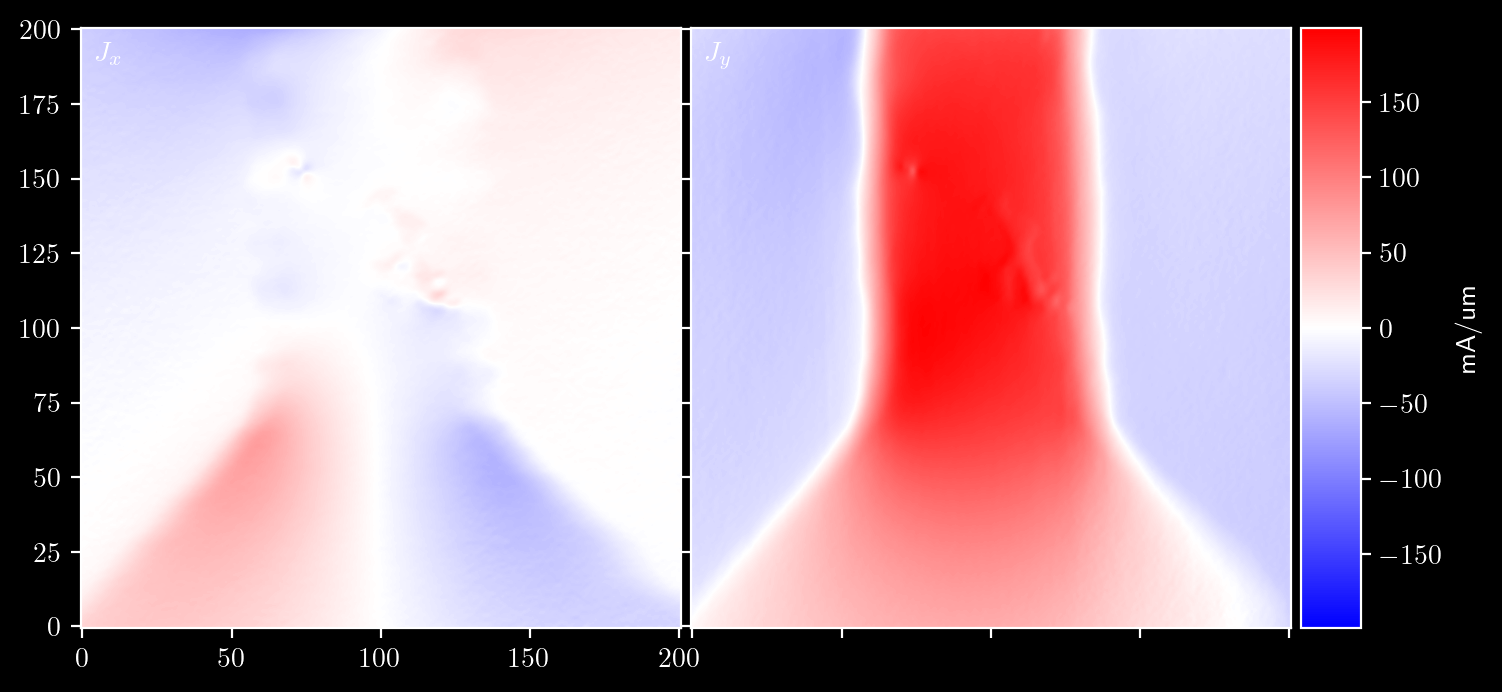

In [135]:
plot_n_components(JxJy[:,100:301,100:301], symmetric=True, labels=[r"$J_x$", r"$J_y$"], cmap="bwr", units="mA/um",
imshow_kwargs={
    "interpolation": "bicubic",
    })

## Background substraction

Above we see that $J_x$, $J_y$ reconstruction has artifacts in a form of sort of background offsets. $J_y$ artifact is in the form of a background constant spatial DC offset, whereas $J_x$ is a more complicated one: Maybe it can be corrected by a plane $J_{x, \text{offset}} = ax + by$? 

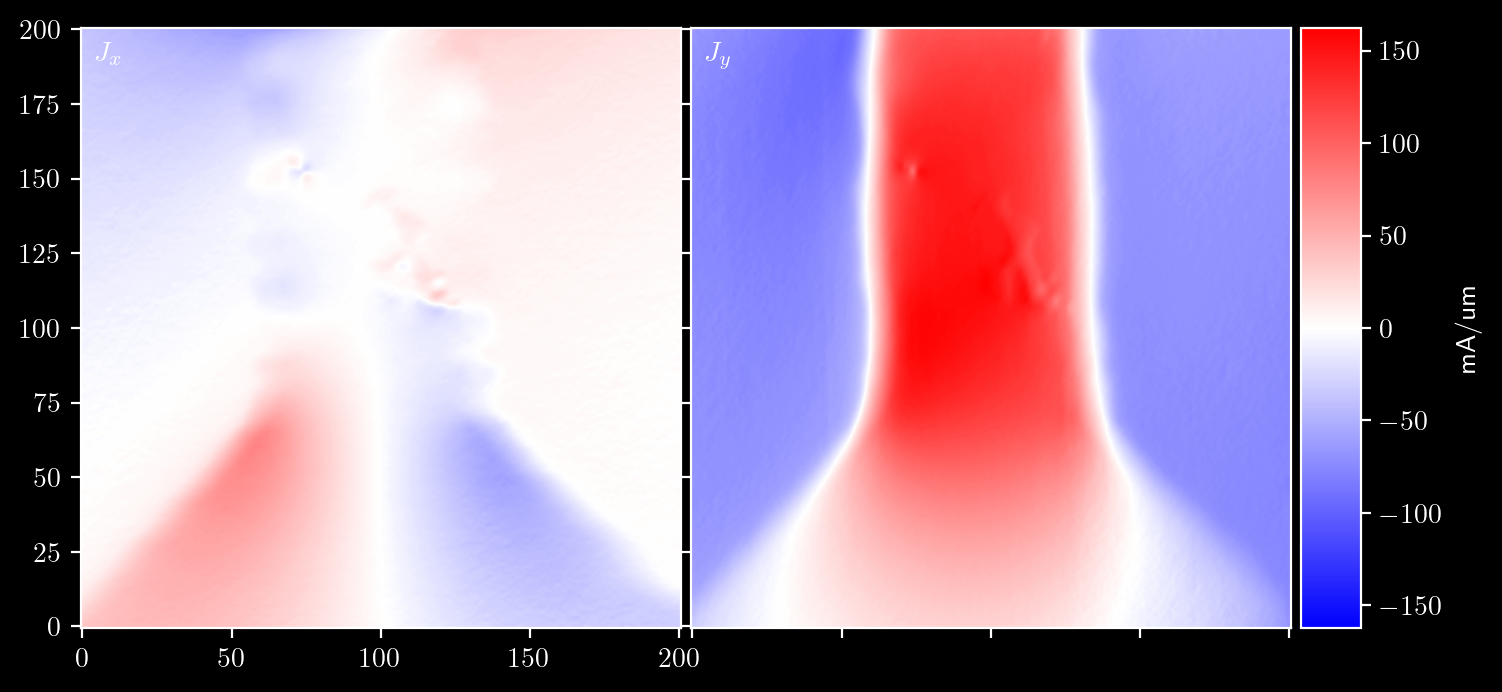

In [136]:
# there is a wrong way to correct the current density by subtracting the mean of each component across the image
# plotting the result, we see that the effect is not becaucase of the mean shift
def wrong_correct_background(J: torch.tensor):
    J = J - J.mean(dim=(-2, -1), keepdim=True)
    return J

plot_n_components(wrong_correct_background(JxJy[:,100:301,100:301]), symmetric=True, labels=[r"$J_x$", r"$J_y$"], cmap="bwr", units="mA/um",
imshow_kwargs={
    "interpolation": "bicubic",
    })


In [137]:
def correct_background(J: torch.tensor):
    # that's the region where J_y component should be zero but it is not
    Jy_zero_region = J[1, 150:200, 150:200]
    Jy_offset = Jy_zero_region.mean()

    Jx_zero_region_1 = J[0, 0:50, 150:200]
    Jx_offset_1 = Jx_zero_region_1.mean()

    Jx_zero_region_2 = J[0, 150:200, 150:200]
    Jx_offset_2 = Jx_zero_region_2.mean()
    
    # for J_x component, we want to correct for a linear variation so that the values for the Jx_offset 
    # vary from Jx_offset_1 to Jx_offset_2 across the width of the image
    Jx_offset = torch.linspace(Jx_offset_1, Jx_offset_2, J.shape[-2])
    J[0, :, :] = J[0, :, :] - Jx_offset[:, None]
    J[1, :, :] = J[1, :, :] - Jy_offset
    plot_n_components(J, symmetric=True, cmap="bwr", show=True)
    return J

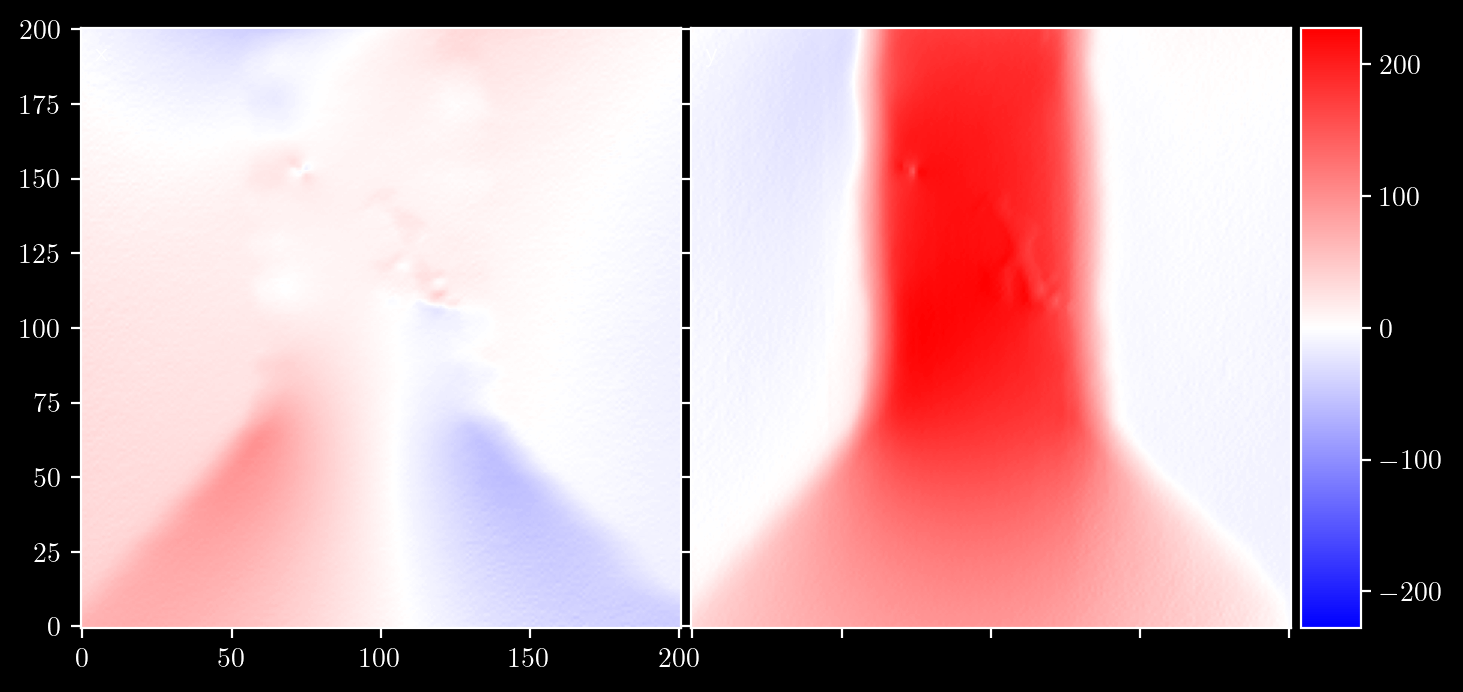

In [138]:
J_corrected = correct_background(JxJy[:,100:301,100:301])

Check that the reconstructed current produces the expected magnetic field. For that, take `JxJy` and input it into a reasonable propagator algorithm to obtain $B$ field.



In [139]:
from magrec.prop.Propagator import HeightContinuationPadder, ZeroPadder, CurrentPropagator2d, AxisProjectionPropagator

In [140]:
shape = J_corrected.shape
pad1 = HeightContinuationPadder(shape=shape)
pad2 = ZeroPadder(shape=pad1.expanded_shape)
propagator = CurrentPropagator2d(source_shape=pad2.expanded_shape,
                                 dx=dx, dy=dy, height=height, layer_thickness=layer_thickness,)
proj = AxisProjectionPropagator(theta=theta, phi=phi)

def compute_B(J: torch.tensor):
    J = pad1.pad(J)
    fig = plot_n_components(J, symmetric=True, labels=[r"$J_x$", r"$J_y$"], cmap="bwr", show=True)
    fig.suptitle("Padded J", y=0.86)
    J = pad2.pad(J)
    B = propagator(J)
    B = pad2.unpad(B)
    B = pad1.unpad(B)
    B_NV = proj.project(B)
    B = torch.concat((B, B_NV[None, ...]), dim=0)
    return B


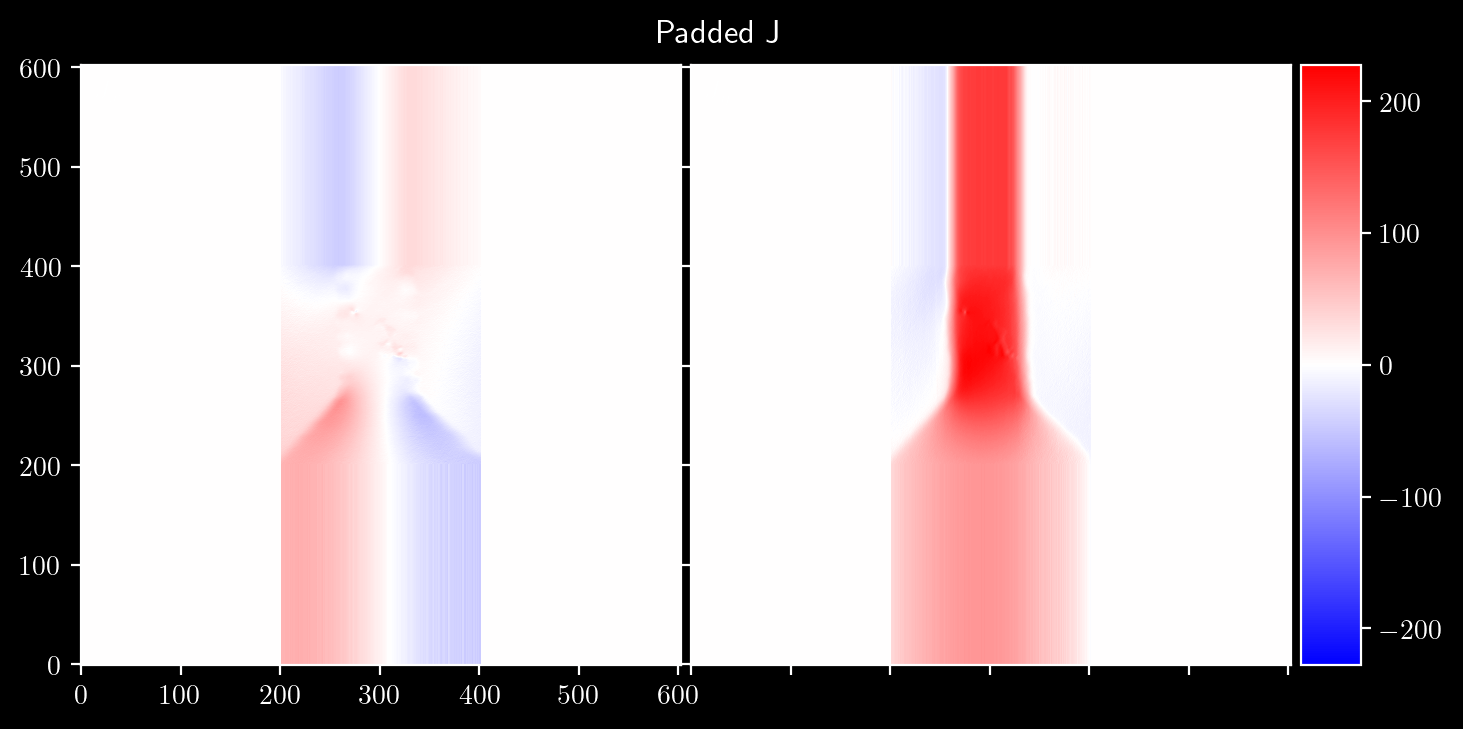

In [141]:
reconstructedB = compute_B(J_corrected)

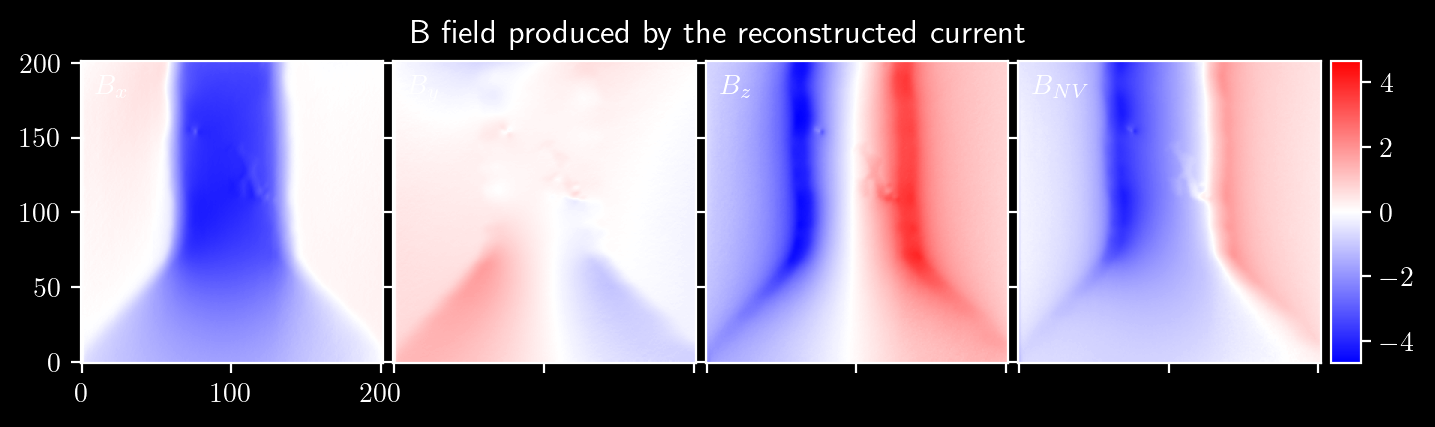

In [142]:
fig = plot_n_components(reconstructedB, labels=[r'$B_x$', '$B_y$',
                  '$B_z$', '$B_{NV}$'], cmap="bwr")
fig.suptitle("B field produced by the reconstructed current", y=0.7)
fig

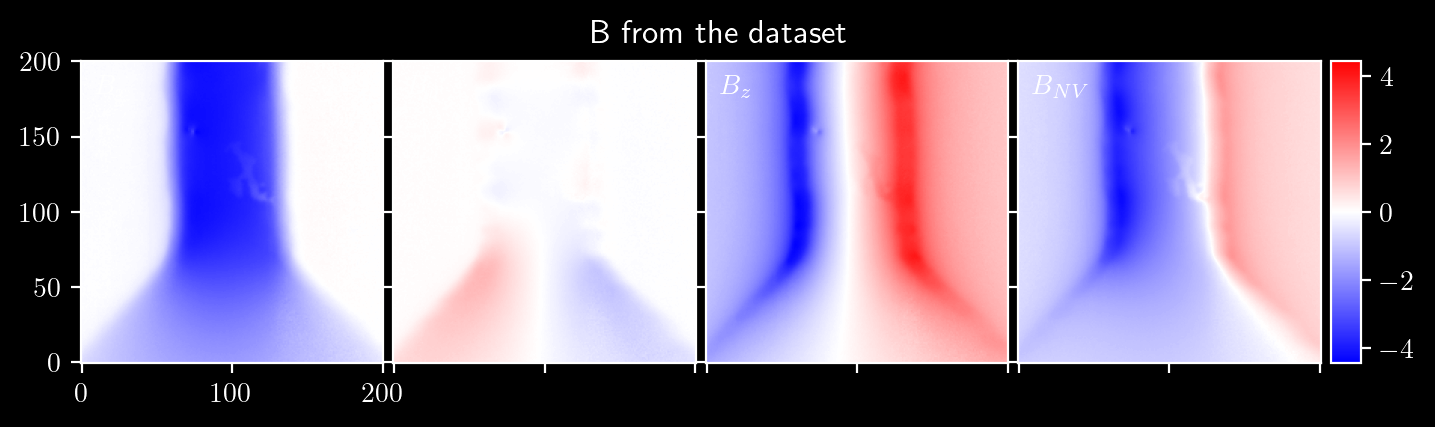

In [143]:
fig = plot_n_components(B, labels=[r'$B_x$', '$B_y$',
                  '$B_z$', '$B_{NV}$'], cmap="bwr")
fig.suptitle("B from the dataset", y=0.7)
fig